In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
import utils
from utils import TimeSeries
from scipy.signal import fftconvolve
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create a Retina object that can hold the entire Argus I array (4x4 checkerboard, 880um center-to-center)
# width: 4 x 880um = 3520um, but add radii: 3520um + 130um + 260um = 3910 um, then add padding for current spread -> 5000um
r_sampling = 50  # spatial sampling of retina
r = e2cm.Retina(axon_map='../retina_argus_s' + str(r_sampling) + '.npz', 
                sampling=r_sampling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [4]:
# Create Argus I electrode array 
# 4x4 checkerboard, 880um center-to-center, (almost) alternating electrode sizes

e_spacing = 880  # um
x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

# spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
#   .  o  .  o
#   o  .  o  .
#   .  o  .  o
#   o  .  o  .
r_arr = np.array([260, 520, 260, 520])
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*0

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(), y_coord.flatten().tolist(), h_arr.tolist())

In [5]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = r.electrode_ecs(e_all)

In [6]:
e_rf = []
for e in e_all.electrodes:
    e_rf.append(e2cm.receptive_field(e, r.gridx, r.gridy, e_spacing))

In [7]:
def psycho2stim(r, dur, freq, tsample):
    # for now, keep most params constant except for frequency and overall stimulus duration
    p2pt = e2cm.Psycho2Pulsetrain(freq, dur, pulse_dur=.075/1000, interphase_dur=.075/1000, 
                                  tsample=tsample, current_amplitude=20, pulsetype='cathodicfirst')
    
    # convert to ecm TimeSeries
    ecs_list = []
    for xx in range(r.gridx.shape[1]):
        for yy in range(r.gridx.shape[0]):
            if np.all(ecs[yy,xx] < 0.01):
                pass
            else:
                ecs_list.append(ecs[yy,xx])
                
    return e2cm.ecm(ecs_list[0], p2pt.data, tsample)

def speedup(data, data_ref):
    # returns a speedup factor for a list of execution times `data` compared to reference data `data_ref`
    return np.mean(data_ref / data)

def percent_faster(data, data_ref):
    # returns how much faster a list of execution times `data` is compared to reference data `data_ref` (%)
    return np.mean((data_ref - data) / data_ref) * 100

In [8]:
# global specs
tsample=.005/1000.
fps = 30
rs = 1/(fps*tsample)

tau1 = .42/1000
tau2 = 45.25/1000
tau3 = 26.25/1000
dojit=True

# pre-calc gamma
t = np.arange(0, 20*tau1, tsample)
gamma1 = e2cm.gamma(1, tau1, t)
t = np.arange(0, 8*tau2, tsample)
gamma2 = e2cm.gamma(1, tau2, t)
t = np.arange(0, 8*tau3, tsample)
gamma3 = e2cm.gamma(3, tau3, t)

In [9]:
# sweep stimulus duration, but keep stimulus frequency fixed
freq=20
num_pts = 11
duration = np.linspace(0.1, 1, num_pts)

In [10]:
# Step 1: Optimize fast response
# ------------------------------
#
# In the following, stim is a TimeSeries object

def fr_ref(stim, tau1=.42/1000, dojit=True):
    # fast response: reference implementation
    t = np.arange(0, 20 * tau1, stim.tsample)
    g = e2cm.gamma(1, tau1, t)
    R1 = stim.tsample * utils.sparseconv(g, stim.data, dojit)
    return TimeSeries(stim.tsample, R1)

def fr_prealloc(stim, gamma, dojit=True):
    # pre-allocate gamma function instead of computing it every time step
    R1 = stim.tsample * utils.sparseconv(gamma, stim.data, dojit, mode='same')
    return TimeSeries(stim.tsample, R1)

def fr_prealloc_numpy(stim, gamma, dojit=True):
    # pre-allocate gamma, don't convert to TimeSeries
    return stim.tsample * utils.sparseconv(gamma, stim.data, dojit, mode='same')

In [11]:
t_fr_ref = []
t_fr_prealloc = []
t_fr_prealloc_numpy = []

for dur in duration:
    ecss = psycho2stim(r, dur, freq, tsample)

    t0 = %timeit -oq fr_ref(ecss, tau1, dojit)
    t1 = %timeit -oq fr_prealloc(ecss, gamma1, dojit)
    t2 = %timeit -oq fr_prealloc_numpy(ecss, gamma1, dojit)

    t_fr_ref.append(t0.best)
    t_fr_prealloc.append(t1.best)
    t_fr_prealloc_numpy.append(t2.best)

In [12]:
t_fr_ref = np.array(t_fr_ref)
t_fr_prealloc = np.array(t_fr_prealloc)
t_fr_prealloc_numpy = np.array(t_fr_prealloc_numpy)

prealloc:		avg speedup 1.113x		avg 9.4% faster
prealloc + numpy:	avg speedup 1.933x		avg 47.8% faster


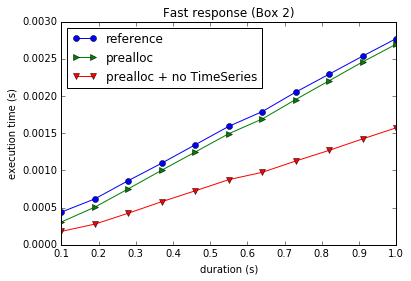

In [13]:
plt.plot(duration, t_fr_ref, '-o', label='reference')
plt.plot(duration, t_fr_prealloc, '->', label='prealloc')
plt.plot(duration, t_fr_prealloc_numpy, '-v', label='prealloc + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Fast response (Box 2)')

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_fr_prealloc, t_fr_ref), 
                                                               percent_faster(t_fr_prealloc, t_fr_ref)))
print('prealloc + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_fr_prealloc_numpy, t_fr_ref),
                                                                     percent_faster(t_fr_prealloc_numpy, t_fr_ref)))

In [14]:
# Step 2: Optimize charge accumulation
# ------------------------------------

# TODO

# def ca_ref(fr, ecm, tau2=45.25/1000, e=8.73):
#     t = np.arange(0, 8 * tau1, fr.tsample)
#     gamma2 = e2cm.gamma(1, tau2, t)

#     rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
#     ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
#     charge_acc = e * fr.tsample * fftconvolve(ca, gamma2)
    
#     b3 = fr.data - charge_acc
#     b3 = np.where(b3 > 0, b3, 0) # rectify again
#     return TimeSeries(fr.tsample, b3)

# def ca_prealloc(fr, ecm, gamma2, e=8.73):
#     rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
#     ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
#     charge_acc = e * fr.tsample * fftconvolve(ca, gamma2, mode='same')
    
#     b3 = fr.data - charge_acc
#     b3 = np.where(b3 > 0, b3, 0) # rectify again
#     return TimeSeries(fr.tsample, b3)

# def ca_prealloc_numpy(fr, ecm, gamma2, e=8.73):
#     # fr is numpy array
#     rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
#     ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
#     charge_acc = e * ecm.tsample * fftconvolve(ca, gamma2, mode='same')
    
#     b3 = fr - charge_acc
#     return np.where(b3 > 0, b3, 0) # rectify again

In [15]:
# t_ca_ref = []
# t_ca_prealloc = []
# t_ca_prealloc_nopad_numpy = []

# for dur in duration:
#     ecss = psycho2stim(r, dur, freq, tsample)
#     fr = fr_prealloc(ecss, gamma1, dojit)

#     t0 = %timeit -oq ca_ref(fr, ecss, tau2)
#     t1 = %timeit -oq ca_prealloc(fr, ecss, gamma2)
#     t2 = %timeit -oq ca_prealloc_numpy(fr, ecss, gamma2)

#     t_ca_ref.append(t0.best)
#     t_ca_prealloc.append(t1.best)
#     t_ca_prealloc_numpy.append(t2.best)

In [16]:
# t_fr_ref = np.array(t_fr_ref)
# t_fr_prealloc = np.array(t_fr_prealloc)
# t_fr_prealloc_numpy = np.array(t_fr_prealloc_numpy)

In [17]:
# Step 3: Optimize stationary nonlinearity
# ----------------------------------------

def sn_ref(stim, asymptote, slope, shift):
    # static nonlinearity, reference implementation
    # expects stim to be a TimeSeries object
    R3norm = stim.data / stim.data.max()
    scale_factor = asymptote / (1 + np.exp(-(stim.data / slope) + shift))
    R4 = R3norm * scale_factor
    return TimeSeries(stim.tsample, R4)

def sn_nanduri(stim, asymptote, slope, shift):
    # use exact equation from Nanduri et al. (2012)
    # expects stim to be a TimeSeries object
    scale_factor = asymptote / (1 + np.exp((shift - stim.data.max()) / slope))
    R4 = stim.data * scale_factor
    return TimeSeries(stim.tsample, R4)

def sn_nanduri_expit(stim, asymptote, slope, shift):
    # use Nanduri eq. and expit to speed up logistic function
    # expects stim to be a TimeSeries object
    scale_factor = asymptote * expit((stim.data.max() - shift) / slope)
    return TimeSeries(stim.tsample, stim.data * scale_factor)

def sn_nanduri_expit_numpy(stim, asymptote, slope, shift):
    # use Nanduri eq., expit, and don't convert to/from TimeSeries object
    # expects stim to be a np.array
    return stim * asymptote * expit((stim.max() - shift) / slope)

In [18]:
t_sn_ref = []
t_sn_nanduri = []
t_sn_nanduri_expit = []
t_sn_nanduri_expit_numpy = []

asymptote = 14
slope = 3
shift = 16

for dur in duration:
    ecss = psycho2stim(r, dur, freq, tsample)
    fr = fr_prealloc(ecss, gamma1, dojit)

    t0 = %timeit -oq sn_ref(fr, asymptote, slope, shift)
    t1 = %timeit -oq sn_nanduri(fr, asymptote, slope, shift)
    t2 = %timeit -oq sn_nanduri_expit(fr, asymptote, slope, shift)
    t3 = %timeit -oq sn_nanduri_expit_numpy(fr.data, asymptote, slope, shift)

    t_sn_ref.append(t0.best)
    t_sn_nanduri.append(t1.best)
    t_sn_nanduri_expit.append(t2.best)
    t_sn_nanduri_expit_numpy.append(t3.best)

In [19]:
t_sn_ref = np.array(t_sn_ref)
t_sn_nanduri = np.array(t_sn_nanduri)
t_sn_nanduri_expit = np.array(t_sn_nanduri_expit)
t_sn_nanduri_expit_numpy = np.array(t_sn_nanduri_expit_numpy)

nanduri:			avg speedup 5.555x		avg 82.0% faster
nanduri + expit:		avg speedup 5.557x		avg 82.0% faster
nanduri + expit + numpy:	avg speedup 20.800x		avg 95.2% faster


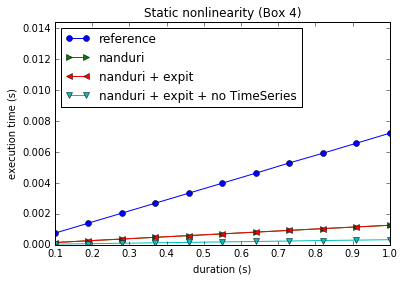

In [20]:
plt.plot(duration, t_sn_ref, '-o', label='reference')
plt.plot(duration, t_sn_nanduri, '->', label='nanduri')
plt.plot(duration, t_sn_nanduri_expit, '-<', label='nanduri + expit')
plt.plot(duration, t_sn_nanduri_expit_numpy, '-v', label='nanduri + expit + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Static nonlinearity (Box 4)')
plt.axis([duration.min(), duration.max(), 0, t_sn_ref.max()*2])

print('nanduri:\t\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri, t_sn_ref),
                                                                percent_faster(t_sn_nanduri, t_sn_ref)))
print('nanduri + expit:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri_expit, t_sn_ref),
                                                                      percent_faster(t_sn_nanduri_expit, t_sn_ref)))
print('nanduri + expit + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri_expit_numpy, t_sn_ref),
                                                                            percent_faster(t_sn_nanduri_expit_numpy, t_sn_ref)))

In [21]:
# Step 4: Optimize slow response
# ------------------------------

def sr_ref(stim, tau3):
    # slow response, reference implementation
    # expects stim to be a TimeSeries object
    t = np.arange(0, tau3 * 8, stim.tsample)
    g = e2cm.gamma(3, tau3, t)
    c = fftconvolve(stim.data, g)
    return TimeSeries(stim.tsample, stim.tsample * c)

def sr_prealloc(stim, gamma):
    c = fftconvolve(stim.data, gamma, mode='same')
    return TimeSeries(stim.tsample, stim.tsample * c)

def sr_prealloc_numpy(stim, gamma, tsample):
    # preallocate gamma, first fft arg is longest, don't convert to TimeSeries
    # expects stim to be a np.array
    return tsample * fftconvolve(stim, gamma, mode='same')

In [23]:
t_sr_ref = []
t_sr_prealloc = []
t_sr_prealloc_numpy = []

for dur in duration:
    ecss = psycho2stim(r, dur, freq, tsample)
    fr = fr_prealloc(ecss, gamma1, dojit)
    sn = sn_nanduri_expit(fr, asymptote, slope, shift)

    t0 = %timeit -oq sr_ref(sn, tau3)
    t1 = %timeit -oq sr_prealloc(sn, gamma3)
    t2 = %timeit -oq sr_prealloc_numpy(sn.data, gamma3, tsample)

    t_sr_ref.append(t0.best)
    t_sr_prealloc.append(t1.best)
    t_sr_prealloc_numpy.append(t2.best)

In [24]:
t_sr_ref = np.array(t_sr_ref)
t_sr_prealloc = np.array(t_sr_prealloc)
t_sr_prealloc_numpy = np.array(t_sr_prealloc_numpy)

prealloc:		avg speedup 1.240x		avg 18.7% faster
prealloc + numpy:	avg speedup 1.320x		avg 23.7% faster


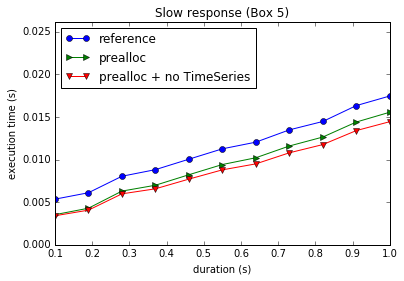

In [28]:
plt.plot(duration, t_sr_ref, '-o', label='reference')
plt.plot(duration, t_sr_prealloc, '->', label='prealloc')
plt.plot(duration, t_sr_prealloc_numpy, '-v', label='prealloc + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Slow response (Box 5)')
plt.axis([duration.min(), duration.max(), 0, t_sr_ref.max()*1.5])

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sr_prealloc, t_sr_ref),
                                                                  percent_faster(t_sr_prealloc, t_sr_ref)))
print('prealloc + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sr_prealloc_numpy, t_sr_ref),
                                                                             percent_faster(t_sr_prealloc_numpy, t_sr_ref)))

In [29]:
# Step 5: Compare performance across the full cascade
# ---------------------------------------------------

def cascade_ref(ecss, tau1, tau3, asymptote, slope, shift, dojit):
    fr = fr_ref(ecss, tau1, dojit)
    sn = sn_ref(fr, asymptote, slope, shift)
    sr = sr_ref(sn, tau3)
    
def cascade_prealloc(ecss, gamma1, gamma3, asymptote, slope, shift, dojit):
    fr = fr_prealloc(ecss, gamma1, dojit)
    sn = sn_ref(fr, asymptote, slope, shift)
    sr = sr_prealloc(sn, gamma3)
    
def cascade_all_nanduri(ecss, gamma1, gamma3, asymptote, slope, shift, dojit):
    fr = fr_prealloc_numpy(ecss, gamma1, dojit)
    sn = sn_nanduri_expit_numpy(fr, asymptote, slope, shift)
    sr = sr_prealloc_numpy(sn, gamma3, ecss.tsample)

In [30]:
t_casc_ref = []
t_casc_prealloc = []
t_casc_all_nanduri = []

for dur in duration:
    ecss = psycho2stim(r, dur, freq, tsample)
    
    t0 = %timeit -oq cascade_ref(ecss, tau1, tau3, asymptote, slope, shift, dojit)
    t1 = %timeit -oq cascade_prealloc(ecss, gamma1, gamma3, asymptote, slope, shift, dojit)
    t2 = %timeit -oq cascade_all_nanduri(ecss, gamma1, gamma3, asymptote, slope, shift, dojit)

    t_casc_ref.append(t0.best)
    t_casc_prealloc.append(t1.best)
    t_casc_all_nanduri.append(t2.best)

In [31]:
t_casc_ref = np.array(t_casc_ref)
t_casc_prealloc = np.array(t_casc_prealloc)
t_casc_all_nanduri = np.array(t_casc_all_nanduri)

prealloc:		avg speedup 1.181x		avg 14.7% faster
all nanduri:		avg speedup 1.749x		avg 42.7% faster


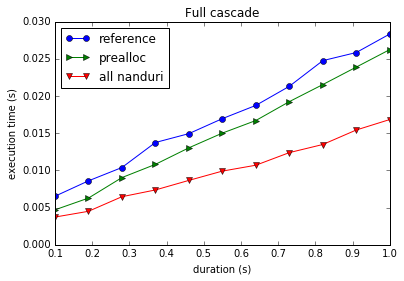

In [32]:
plt.plot(duration, t_casc_ref, '-o', label='reference')
plt.plot(duration, t_casc_prealloc, '->', label='prealloc')
plt.plot(duration, t_casc_all_nanduri, '-v', label='all nanduri')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Full cascade')

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_casc_prealloc, t_casc_ref),
                                                             percent_faster(t_casc_prealloc, t_casc_ref)))
print('all nanduri:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_casc_all_nanduri, t_casc_ref),
                                                                  percent_faster(t_casc_all_nanduri, t_casc_ref)))

In [33]:
t_freq_ref = []
t_freq_prealloc = []
t_freq_all_nanduri = []

frequencies = np.linspace(5, 60, 12)

for hz in frequencies:
    ecss = psycho2stim(r, 0.5, hz, tsample)
    
    t0 = %timeit -oq cascade_ref(ecss, tau1, tau3, asymptote, slope, shift, dojit)
    t1 = %timeit -oq cascade_prealloc(ecss, gamma1, gamma3, asymptote, slope, shift, dojit)
    t2 = %timeit -oq cascade_all_nanduri(ecss, gamma1, gamma3, asymptote, slope, shift, dojit)

    t_freq_ref.append(t0.best)
    t_freq_prealloc.append(t1.best)
    t_freq_all_nanduri.append(t2.best)

In [34]:
t_freq_ref = np.array(t_freq_ref)
t_freq_prealloc = np.array(t_freq_prealloc)
t_freq_all_nanduri = np.array(t_freq_all_nanduri)

prealloc:		avg speedup 1.143x		avg 12.5% faster
all nanduri:		avg speedup 1.724x		avg 42.0% faster


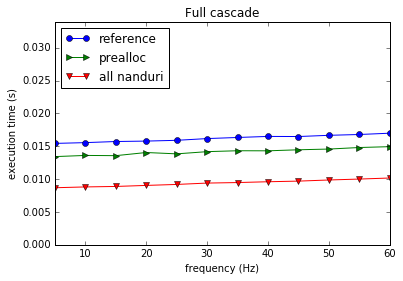

In [35]:
plt.plot(frequencies, t_freq_ref, '-o', label='reference')
plt.plot(frequencies, t_freq_prealloc, '->', label='prealloc')
plt.plot(frequencies, t_freq_all_nanduri, '-v', label='all nanduri')
plt.xlabel('frequency (Hz)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Full cascade')
plt.axis([frequencies.min(), frequencies.max(), 0, t_freq_ref.max()*2])

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_freq_prealloc, t_freq_ref),
                                                             percent_faster(t_freq_prealloc, t_freq_ref)))
print('all nanduri:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_freq_all_nanduri, t_freq_ref),
                                                                  percent_faster(t_freq_all_nanduri, t_freq_ref)))